# Manual reduction

the primary goal of prose is to be able to have fine control over FITS processing pipelines. Here we propose to go through the reduction and photometry of an observation using prose fundamental components: the `Block` and `Sequence` objects

## Synthetic data

Let's generate some synthetic data to work with

In [1]:
import numpy as np
from prose.tutorials import simulate_observation

time = np.linspace(0, 0.15, 100)
target_dflux = 1 + np.sin(time*100)*1e-2

np.random.seed(40)
fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

KeyboardInterrupt: 

## Telescope setting and fits manager

As in our previous tutorials we set the telescope (if not set yet)

In [2]:
from prose import Telescope

_ = Telescope({
    "name": "A",
    "trimming": [40, 40],
    "pixel_scale": 0.66,
    "latlong": [31.2027, 7.8586],
    "keyword_light_images": "light"
})

Telescope 'a' saved


and explore our raw images folder using the `FitsManager`

In [3]:
from prose import FitsManager

# Folder exploration
fm = FitsManager(fits_folder)
fm.observations

# Getting observation 0 and retrieving telescope
fm.set_observation(0)
telescope = fm.telescope

100%|██████████| 106/106 [00:00<00:00, 563.60it/s]


╒═════════╤════════════╤═════════════╤══════════╤══════════╤════════════╕
│   index │ date       │ telescope   │ target   │ filter   │   quantity │
╞═════════╪════════════╪═════════════╪══════════╪══════════╪════════════╡
│       0 │ 2021-05-15 │ A           │ prose    │ a        │        100 │
╘═════════╧════════════╧═════════════╧══════════╧══════════╧════════════╛


## Reduction

We will now dig into reducing the raw data using `Block` arranged in `Sequence` in which images are succesively processed.

The first step of the manual reduction is to get a reference image from which we will flip and and align other images accordingly

In [4]:
from prose import Sequence, blocks, viz
from os import path

ref = fm.images[50] # image 50 will be our reference

reference = Sequence([
    blocks.Trim(),
    blocks.SegmentedPeaks(n_stars=50),
    blocks.ImageBuffer(name="buffer")
], ref, telescope=telescope)

reference.run(show_progress=False)

# let's get our reference image
reference_image = reference.buffer.image

Here, for conveniance, we used the `Sequence` although we are processing only a single image. Now that we set a reference image, let's throw all images through the reduction steps

In [6]:
# We first set the destination of our reduction files
destination = f"{fits_folder}_reduced"
stack_path = path.join(destination, "stack.fits")
video_path = path.join(destination, "video.gif")

calibration = Sequence([
    blocks.Trim(skip_wcs=True),
    blocks.Flip(reference_image),
    blocks.SegmentedPeaks(n_stars=50),                            # stars detected for alignment
    blocks.XYShift(reference_image.stars_coords),                 # finding the shift between consecutive images 
    blocks.Moffat2D(),                                            # measure of the effective psf
    blocks.Cutout2D(reference_image.data),                           # full-pixels alignment of the image
    blocks.Stack(stack_path, header=reference_image.header),
    blocks.SaveReduced(destination, name="reduced"),
    blocks.Video(video_path, from_fits=True)
], fm.images, telescope=telescope, name="Reduction")

calibration.run()

RUN Reduction: 100%|██████████████████████| 100/100 [00:15<00:00,  6.36images/s]


This leads to a folder containing all reduced images, a stack fits and a gif of the observation

## Photometry

We can now proceed with the photometry. For that, we use the stack as a reference to get all stars positions. Since we aligned all images during the calibration process, we should be able to work at fixed apertures postions. We also make a measurement of the psf fwhm to adapt the apertures sizes

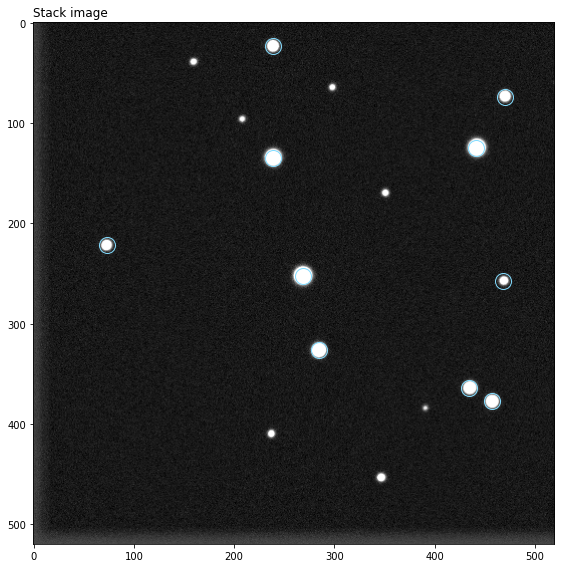

In [7]:
stack_detection = Sequence([
    blocks.SegmentedPeaks(n_stars=50, threshold=1.05), # stars detection
    blocks.Gaussian2D(cutout_size=51, name="psf"),
    blocks.ImageBuffer(name="buffer"),
], stack_path, telescope=telescope)

stack_detection.run(show_progress=False)
stack = stack_detection.buffer.image

# plotting stack and detected stars
viz.show_stars(stack.data, stack.stars_coords, size=8)

Let's now run the photometry. As mentioned before we will set equal stars coordinates and psf size for every image

In [8]:
phot_path = path.join(destination, "observation.phot")

photometry = Sequence([
    blocks.Set(stars_coords=stack.stars_coords), # set same coords for all images
    blocks.Set(fwhm=stack.fwhm),                 # set same fwhm for all images
    blocks.PhotutilsAperturePhotometry(),
    blocks.Get("fluxes")
], calibration.reduced.files, telescope=telescope, name="Photometry")

photometry.run()

RUN Photometry: 100%|█████████████████████| 100/100 [00:06<00:00, 16.07images/s]


## Exploring blocks data

All `Blocks` and `Sequences` used so far contain data obtained from processing all images. There are many ways to access these data, for example:

In [9]:
fluxes = photometry.get("fluxes")

Other options can be found [here](./extra.ipynb). The difference of what we just did compared to the condensed form found in [the photometric reduction tutorial](./reduction.ipynb) is that the latter includes `Blocks` to save the measurements along the way into an [xarray](http://xarray.pydata.org/en/stable/index.html).

In [10]:
# hidden

import shutil
shutil.rmtree(fits_folder)
shutil.rmtree(destination)